In [52]:
## All libraries required
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import tensorflow as tf
%matplotlib inline

In [53]:
## Global Variables
image_path = "images/"
train_org  = pd.read_csv("training.csv")
test_org   = pd.read_csv("test.csv")

In [54]:
train_org.head()
## (x1,y1) is the lower left point and x2-x1 and y2-y1 are the width and height

,image_name,x1,x2,y1,y2
0,JPEG_20160706_121146_1000145715002.png,115,495,143,325
1,JPEG_20161119_174038_1000690577600.png,23,457,61,409
2,147444927651111470309333776-Roadster-Men-Casua...,37,601,13,470
3,147772332675720161028_161611.png,27,602,162,385
4,1473315333651DeeplearnS11638.png,60,586,174,325


In [55]:
test_org.head() ## doesn't have bounding box coordinates 

,image_name,x1,x2,y1,y2
0,1474723840903DSC08089.png,NaN,NaN,NaN,NaN
1,1473231475010DeeplearnS11276.png,NaN,NaN,NaN,NaN
2,JPEG_20161205_135307_1000155917326.png,NaN,NaN,NaN,NaN
3,JPEG_20160711_123440_1000518778437.png,NaN,NaN,NaN,NaN
4,JPEG_20160803_115329_100034020722.png,NaN,NaN,NaN,NaN


In [56]:
train_org.describe()
## Max x coordinate -> 640
## Min x coordinate -> -1
## Max y coordinate -> 480 (full width)
## Min y coordinate -> -1
## -1 means that full product extends beyond the boundaries of image of dimension (480,640)

,x1,x2,y1,y2
count,14000.000000,14000.000000,14000.000000,14000.000000
mean,115.970571,524.558571,88.897214,390.147000
std,73.800382,72.846189,56.172808,55.469778
min,-1.000000,145.000000,-1.000000,159.000000
25%,57.000000,470.000000,42.750000,346.000000
50%,105.000000,534.000000,86.000000,393.000000
75%,170.000000,582.000000,133.000000,435.000000
max,524.000000,640.000000,468.000000,480.000000


In [57]:
test_image_name = test_org["image_name"]
test_image_name.describe()

count                                      12815
unique                                     12815
top       JPEG_20160820_145511_1000731183950.png
freq                                           1
Name: image_name, dtype: object

In [58]:
## Global
train_image_name = train_org["image_name"]
train_image_name.describe()

count                                14000
unique                               14000
top       147742533687520161025_161120.png
freq                                     1
Name: image_name, dtype: object

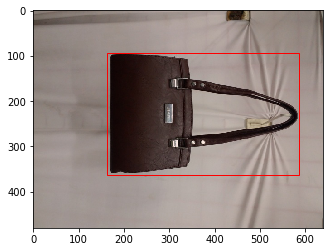

In [223]:
## Random example in train_org 
randn  = 6969
coord  = train_org[train_org["image_name"]==train_image_name[randn]]
x1,y1  = coord['x1'][randn],coord['y1'][randn]
x2,y2  = coord['x2'][randn],coord['y2'][randn]
img    = mpimg.imread(image_path+train_image_name[randn]) ## numpy matrix of shape (width=480,length=640,3
coord  = coord.drop(['image_name'],axis=1)
coord  = coord.values[0]

def plot_img_bb(img,coord) :
    fig,ax = plt.subplots()
    ax.imshow(img)
    rect = patches.Rectangle((coord[0],coord[2]),coord[1]-coord[0],coord[3]-coord[2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

plot_img_bb(img,coord)

In [27]:
img[:,:,1].shape

(480, 640)

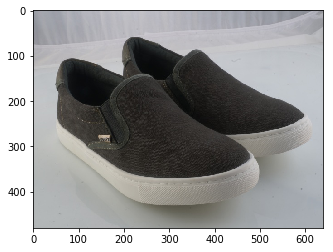

In [101]:
## Random example in test_org
randn  = 4132
img    = mpimg.imread(image_path+test_image_name[randn]) ## numpy matrix of dim (width=480,length=640,3)
fig,ax = plt.subplots()
ax.imshow(img)

In [40]:
img[:,:,1].shape

(480, 640)

In [179]:
## Preparing training and testing set in train_org
np.random.seed(1) ## So that we all get same dataset

train_coord = train_org.copy()
train_coord = train_coord.drop(['image_name'],axis=1)
train_coord = train_coord.values

indices = np.random.permutation(train_coord.shape[0])
split   = int(0.8 * train_coord.shape[0])
train_idx, test_idx = indices[:split],indices[split:]

X_train, X_test = train_image_name[train_idx],train_image_name[test_idx]
X_train.index, X_test.index = range(split), range(len(indices)-split)

y_train, y_test = train_coord[train_idx,:], train_coord[test_idx,:]

In [180]:
train_org[train_org["image_name"]==X_train[9999]]

,image_name,x1,x2,y1,y2
436,JPEG_20161126_145348_1000910481310.png,15,581,73,397


In [181]:
y_train[9999]

array([ 15, 581,  73, 397])

In [191]:
train_org[train_org["image_name"]==X_test[1111]]

,image_name,x1,x2,y1,y2
9449,1473665240573DeeplearnS11459.png,0,580,24,420


In [192]:
y_test[1111]

array([  0, 580,  24, 420])

In [ ]:
## Preparing a function for cross validation set generator

In [ ]:
## Preparing a model for R-CNN (R_CNN is best according to me but )